In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
!nvidia-smi

Thu Sep 17 11:43:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 31%   44C    P2    36W / 250W |   2060MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

loss        0.021494
val_loss    0.055895
dtype: float64


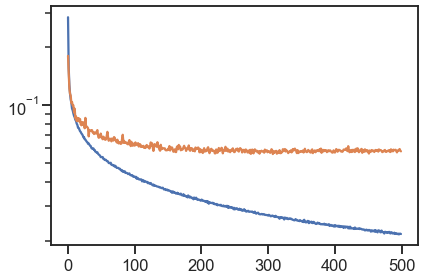

In [3]:
log = pd.read_csv('20200917_redox_atomwise/log.csv').set_index('epoch')

plt.semilogy(log.loss)
plt.semilogy(log.val_loss)
    
print(log.min())

plt.tight_layout()
# plt.xlim([0, 10])

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [5]:
from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

from loss import AtomInfMask, KLWithLogits, RedoxAttention
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    '20200917_redox_atomwise/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{
                       'RedoxAttention': RedoxAttention,
                       'EdgeUpdate': EdgeUpdate,
                       'NodeUpdate': NodeUpdate,
                       'GlobalUpdate': GlobalUpdate}})

In [7]:
from preprocess_inputs_redox import redox_df
redox_df = redox_df.dropna(0, how='all')
redox_df = redox_df.reset_index()

In [8]:
train = np.load('redox_split_nos.npz', allow_pickle=True)['train']

In [9]:
redox_valid = redox_df[~redox_df.smiles.isin(train)]

In [10]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redox_valid.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

In [11]:
predicted_redox = model.predict(test_dataset, verbose=1)

16/16 [==============================] - 3s 172ms/step


Text(0.5, 1.0, 'electron affinity')

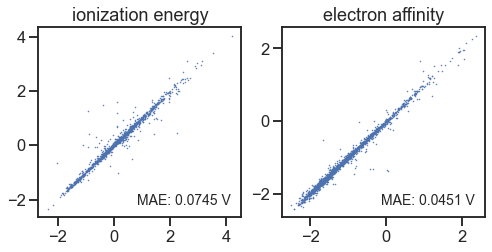

In [63]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3.5))
axs[0].plot(redox_valid['ionization energy'], predicted_redox[:, 0], '.', ms=1)
axs[1].plot(redox_valid['electron affinity'], predicted_redox[:, 1], '.', ms=1)

axs[0].text(.95, .05, f"MAE: {(redox_valid['ionization energy'] - predicted_redox[:, 0]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[0].transAxes, fontsize=14)
axs[1].text(.95, .05, f"MAE: {(redox_valid['electron affinity'] - predicted_redox[:, 1]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('ionization energy')
axs[1].set_title('electron affinity')

In [13]:
redox_valid = redox_valid.copy()
redox_valid['pred ionization energy'] = predicted_redox[:, 0]
redox_valid['pred electron affinity'] = predicted_redox[:, 1]

In [14]:
redox_valid['err ionization energy'] = (redox_valid['pred ionization energy'] - redox_valid['ionization energy']).abs()
redox_valid['err electron affinity'] = (redox_valid['pred electron affinity'] - redox_valid['electron affinity']).abs()

In [34]:
spins = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_spins_expanded.csv.gz')

In [35]:
spins['fractional_spin'] = spins.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

In [36]:
max_fractional_spin = spins.groupby('smiles').fractional_spin.max()

In [40]:
redox_valid_spin = redox_valid.join(max_fractional_spin, on='smiles')

Text(0.5, 1.0, 'Electron Affinity')

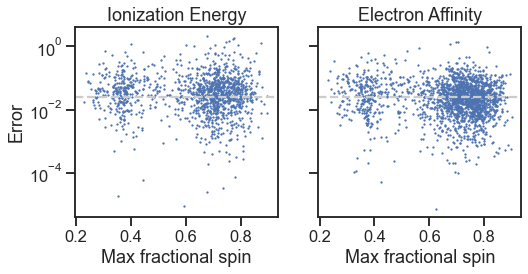

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True, sharex=True)
axs[0].semilogy(redox_valid_spin['fractional_spin'], redox_valid_spin['err ionization energy'], '.', ms=2.5)
axs[0].axhline(0.025, ls='--', color='.8')
axs[1].semilogy(redox_valid_spin['fractional_spin'], redox_valid_spin['err electron affinity'], '.', ms=2.5)
axs[1].axhline(0.025, ls='--', color='.8')

axs[0].set_ylabel('Error')
axs[0].set_xlabel('Max fractional spin')
axs[1].set_xlabel('Max fractional spin')

axs[0].set_title('Ionization Energy')
axs[1].set_title('Electron Affinity')

In [93]:
ie_outliers = redox_valid_spin[redox_valid_spin['fractional_spin'] > 0.75].sort_values('err ionization energy', ascending=False).head(5)
ea_outliers = redox_valid_spin[redox_valid_spin['fractional_spin'] > 0.70].sort_values('err electron affinity', ascending=False).head(5)

In [75]:
import psycopg2

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': 'BD30ps99!',
    'options': f'-c search_path=bde',
}

with psycopg2.connect(**dbparams) as conn:

    redf = pd.read_sql_query("""
    SELECT * from redoxcompound where status='finished'
    """, conn)

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [84]:
ie_outliers[['smiles', 'ionization energy', 'pred ionization energy', 'oxidized_rms', 'fractional_spin']]  # oxidized

,smiles,ionization energy,pred ionization energy,oxidized_rms,fractional_spin
66640,[CH]=C(C)C(=O)C(=O)O,-0.401143,1.482698,0.442732,0.777363
17487,CC(C)[N][N+](=O)[O-],2.229790,0.468276,0.236478,0.770773
35333,COC(=O)[C@H](N)CO[NH],0.120461,1.592959,0.556866,0.756398
61945,[CH2]ON(CC)N=O,-0.874394,0.425241,0.488680,0.873556
59150,[CH2]C[C@@H](C)N=C=O,0.631807,-0.516378,0.369227,0.791781


In [94]:
ea_outliers[['smiles', 'electron affinity', 'pred electron affinity', 'reduced_rms', 'fractional_spin']] 

,smiles,electron affinity,pred electron affinity,reduced_rms,fractional_spin
51055,O=C1C[CH]CNC1=O,0.036434,-1.353550,0.436397,0.702979
55962,[CH2]C(C)(C)C(=O)C=C,-0.340409,-1.307572,0.401526,0.809650
41471,C[C@H]([NH])C(C=O)C=O,-0.708136,-0.017002,0.117294,0.818278
69838,[c]1cc[nH]cc[nH]c1,-1.216652,-0.755029,0.111850,0.734157
3283,C/C=[C]/C1=CC(=O)CC1,0.195971,-0.256310,0.400703,0.743589


In [98]:
ie_logs = redf[redf.smiles.isin(ie_outliers.smiles) & redf.estate.isin(('radical', 'oxidized'))].logfile
ea_logs = redf[redf.smiles.isin(ea_outliers.smiles) & redf.estate.isin(('radical', 'reduced'))].logfile

In [99]:
import shutil

In [103]:
for log in ie_logs:
    shutil.copy(log, '/home/pstjohn/Research/20200608_redox_calculations/spin_gnn/20200917_outliers/ie')

In [104]:
for log in ea_logs:
    shutil.copy(log, '/home/pstjohn/Research/20200608_redox_calculations/spin_gnn/20200917_outliers/ea')

In [102]:
log

'/projects/rlmolecule/pstjohn/redox_calculations/log/872446_e31dec.log.gz'